<a href="https://colab.research.google.com/github/bwilder95/ulmo-warming-stripes/blob/main/warming_stripes_BW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warming Stripes

Let's create our own figure of "[warming stripes](https://en.wikipedia.org/wiki/Warming_stripes)" that use a red/blue color scale to represent annual air temperature deviations from some climate mean tempearture over a long timeseries. This notebook is based on, and adapts code from ["Creating the Warming Stripes in Matplotlib" by Maximilian Nöthe](https://matplotlib.org/matplotblog/posts/warming-stripes/).

In [1]:
!pip install meteostat

---

In [2]:
# packages for working with our data
import pandas as pd
import numpy as np

# page we'll use to access the data
from datetime import datetime
from meteostat import Point, Daily

# packages for plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap

In [3]:
# Set time period
start = datetime(1900, 1, 1)
end = datetime(2021, 12, 31)
# Create Point for San Diego, CA
location = Point(32.715736, -117.161087, 70)
# Get daily data for 2018
data = Daily(location, start, end)
df = data.fetch()

Take a look at what the dataframe looks like

In [4]:
df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
1939-07-01,NaN,16.8,24.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1939-07-02,NaN,17.9,22.9,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1939-07-03,NaN,16.3,21.3,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1939-07-04,NaN,16.8,21.3,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1939-07-05,NaN,17.4,21.8,0.0,0.0,NaN,NaN,NaN,NaN,NaN


Create a daily mean temperature from tmin and tmax

In [5]:
df['tmean'] = np.mean([df.tmax, df.tmin], axis=0)
df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,tmean
time,,,,,,,,,,,
1939-07-01,NaN,16.8,24.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,20.40
1939-07-02,NaN,17.9,22.9,0.0,0.0,NaN,NaN,NaN,NaN,NaN,20.40
1939-07-03,NaN,16.3,21.3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,18.80
1939-07-04,NaN,16.8,21.3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,19.05
1939-07-05,NaN,17.4,21.8,0.0,0.0,NaN,NaN,NaN,NaN,NaN,19.60


Resample the dataframe to annual mean values

In [6]:
df_annual = df.resample('Y').mean()
df_annual.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,tmean
time,,,,,,,,,,,
1939-12-31,NaN,14.590761,23.809783,0.750543,0.0,NaN,NaN,NaN,NaN,NaN,19.200272
1940-12-31,NaN,12.961202,21.402459,1.052459,0.0,NaN,NaN,NaN,NaN,NaN,17.181831
1941-12-31,NaN,12.937534,21.911233,1.736712,0.0,NaN,NaN,NaN,NaN,NaN,17.424384
1942-12-31,15.619388,12.044110,21.228219,0.414247,0.0,249.075735,10.673437,NaN,1015.442268,NaN,16.636164
1943-12-31,NaN,12.469315,21.755068,1.235068,0.0,NaN,NaN,NaN,NaN,NaN,17.112192


Now find the overall mean for all the years we're looking at. We'll use this as our "climate mean" air temperature to compare against just for this example.

In [7]:
climate_mean = df_annual.tmean.mean()
print(climate_mean)

17.731093912496334


Find the annual anomaly between the annual mean temperature and this climate mean.

In [9]:
df_annual['anomaly'] = df_annual.tmean - climate_mean
df_annual = df_annual.reset_index()
df_annual['year'] = pd.DatetimeIndex(df_annual['time']).year
df_annual.head()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,tmean,anomaly,year
0,1939-12-31,NaN,14.590761,23.809783,0.750543,0.0,NaN,NaN,NaN,NaN,NaN,19.200272,1.469178,1939
1,1940-12-31,NaN,12.961202,21.402459,1.052459,0.0,NaN,NaN,NaN,NaN,NaN,17.181831,-0.549263,1940
2,1941-12-31,NaN,12.937534,21.911233,1.736712,0.0,NaN,NaN,NaN,NaN,NaN,17.424384,-0.306710,1941
3,1942-12-31,15.619388,12.044110,21.228219,0.414247,0.0,249.075735,10.673437,NaN,1015.442268,NaN,16.636164,-1.094930,1942
4,1943-12-31,NaN,12.469315,21.755068,1.235068,0.0,NaN,NaN,NaN,NaN,NaN,17.112192,-0.618902,1943


Now that we have our data all in order, we can go ahead and make the plot. (The following plotting code is adapted from ["Creating the Warming Stripes in Matplotlib" by Maximilian Nöthe](https://matplotlib.org/matplotblog/posts/warming-stripes/))

This is our custom colormap from [colorbrewer2](http://colorbrewer2.org), we could also use one of the [colormaps](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) that come with `matplotlib`, e.g. `coolwarm` or `RdBu`.

In [10]:
cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
])

Finally, we create bars for each year as a [PatchCollection](https://matplotlib.org/3.3.2/gallery/shapes_and_collections/patch_collection.html) of [Rectangles](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.patches.Rectangle.html), make the plot and save it as a jpg image.

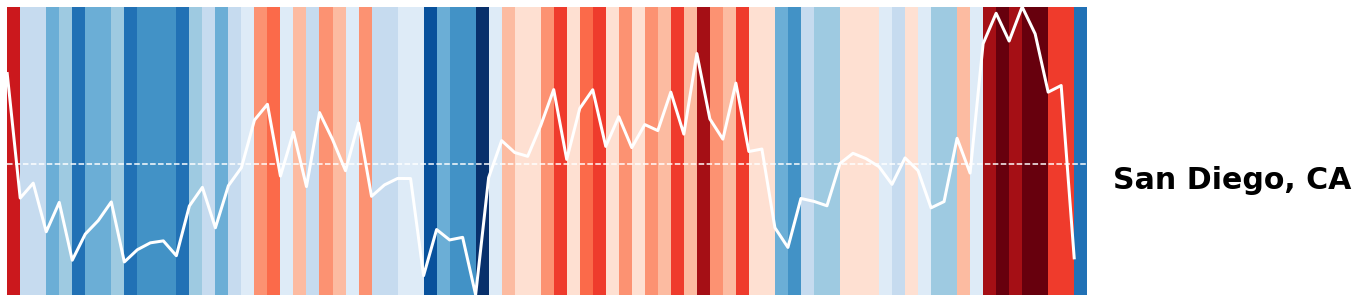

In [11]:
# Define the shape of each bar
rect_ll_y = df_annual.anomaly.min() # rectangle lower left y coordinate, minimum anomaly value
rect_height = np.abs(df_annual.anomaly.max()-df_annual.anomaly.min()) # rectangle height, range between min and max anomaly values
year_start = df_annual.year.min() # year to start the plot x axis
year_end = df_annual.year.max() + 1 # year to end the plot x axis

# create a collection with a rectangle for each year
col = PatchCollection([
    Rectangle((x, rect_ll_y), 1, rect_height)
    for x in range(year_start, year_end)
])

# Create the figure, assign the data, colormap and color limits and add it to the figure axes
fig = plt.figure(figsize=(15, 4))

# set up the axes
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()

# set data, colormap and color limits
col.set_array(df_annual.anomaly) # use the anomaly data for the colormap
col.set_cmap(cmap) # apply our custom red/blue colormap colors
col.set_clim(-rect_height/2, rect_height/2) # set the limits of our colormap
ax.add_collection(col)

# plot anomaly graph
df_annual.plot(x='year', y='anomaly', linestyle='-',lw=3,color='w',ax=ax, legend=False)
# plot horizontal line at zero anomaly
ax.axhline(0, linestyle='--', color='w')
# plot a text label
ax.text(df_annual.year.max()+3,-.4,'San Diego, CA', fontsize=30, fontweight='bold', color='k')

# Make sure the axes limits are correct and save the figure.
ax.set_ylim(-np.abs(df_annual.anomaly.min()), np.abs(df_annual.anomaly.max())) # set y axis limits to rectanlge height centered at zero
ax.set_xlim(year_start, year_end); # set x axes limits to start and end year

# save the figure
#fig.savefig('warming-stripes-seattle.jpg', dpi=150, bbox_inches='tight')